In [1]:
from yellowbrick.datasets.loaders import load_credit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_credit = load_credit(return_dataset=True).to_dataframe()

In [3]:
df_credit.drop_duplicates()

,limit,sex,edu,married,age,apr_delay,may_delay,jun_delay,jul_delay,aug_delay,...,jul_bill,aug_bill,sep_bill,apr_pay,may_pay,jun_pay,jul_pay,aug_pay,sep_pay,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


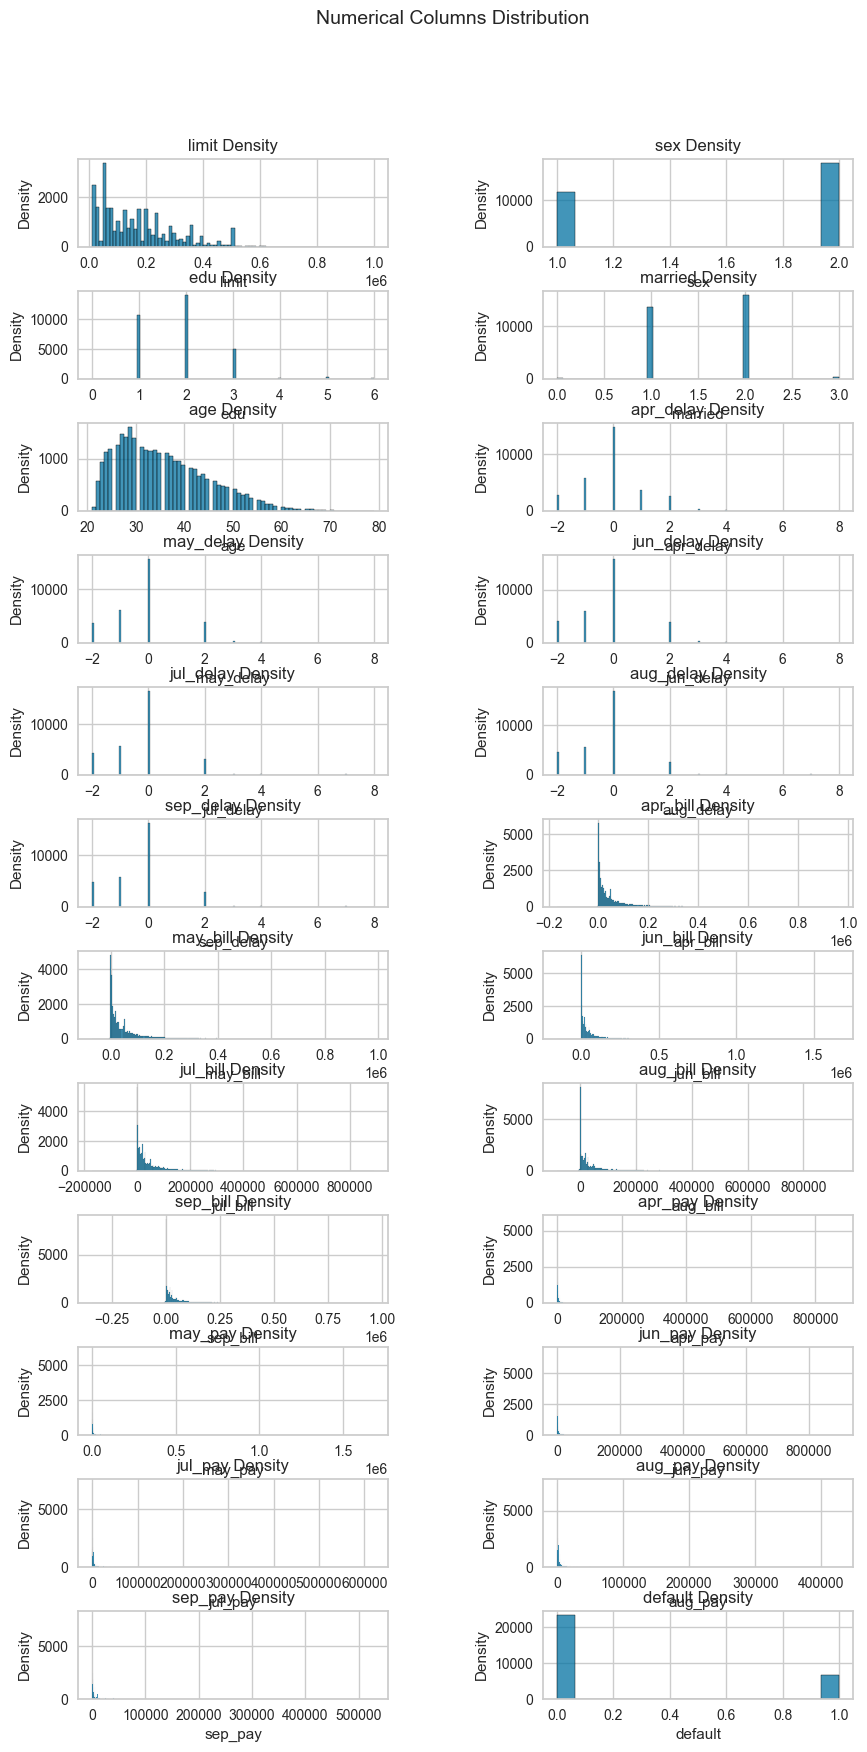

In [4]:
fig, axes = plt.subplots(12, 2, figsize=(10, 20))
for i, col in enumerate(df_credit.columns):
    r,c=i//2,i%2
    sns.histplot(x=col, data=df_credit,ax=axes[r,c])
    axes[i//2,i%2].set_ylabel("Density")
    axes[i//2,i%2].set_title(f"{col} Density")
if len(df_credit) % 2 != 0:
    fig.delaxes(axes[-1, -1])
plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig.text(0.5,0.95,"Numerical Columns Distribution",va="center", ha="center", fontsize=14)
plt.show()

<AxesSubplot: >

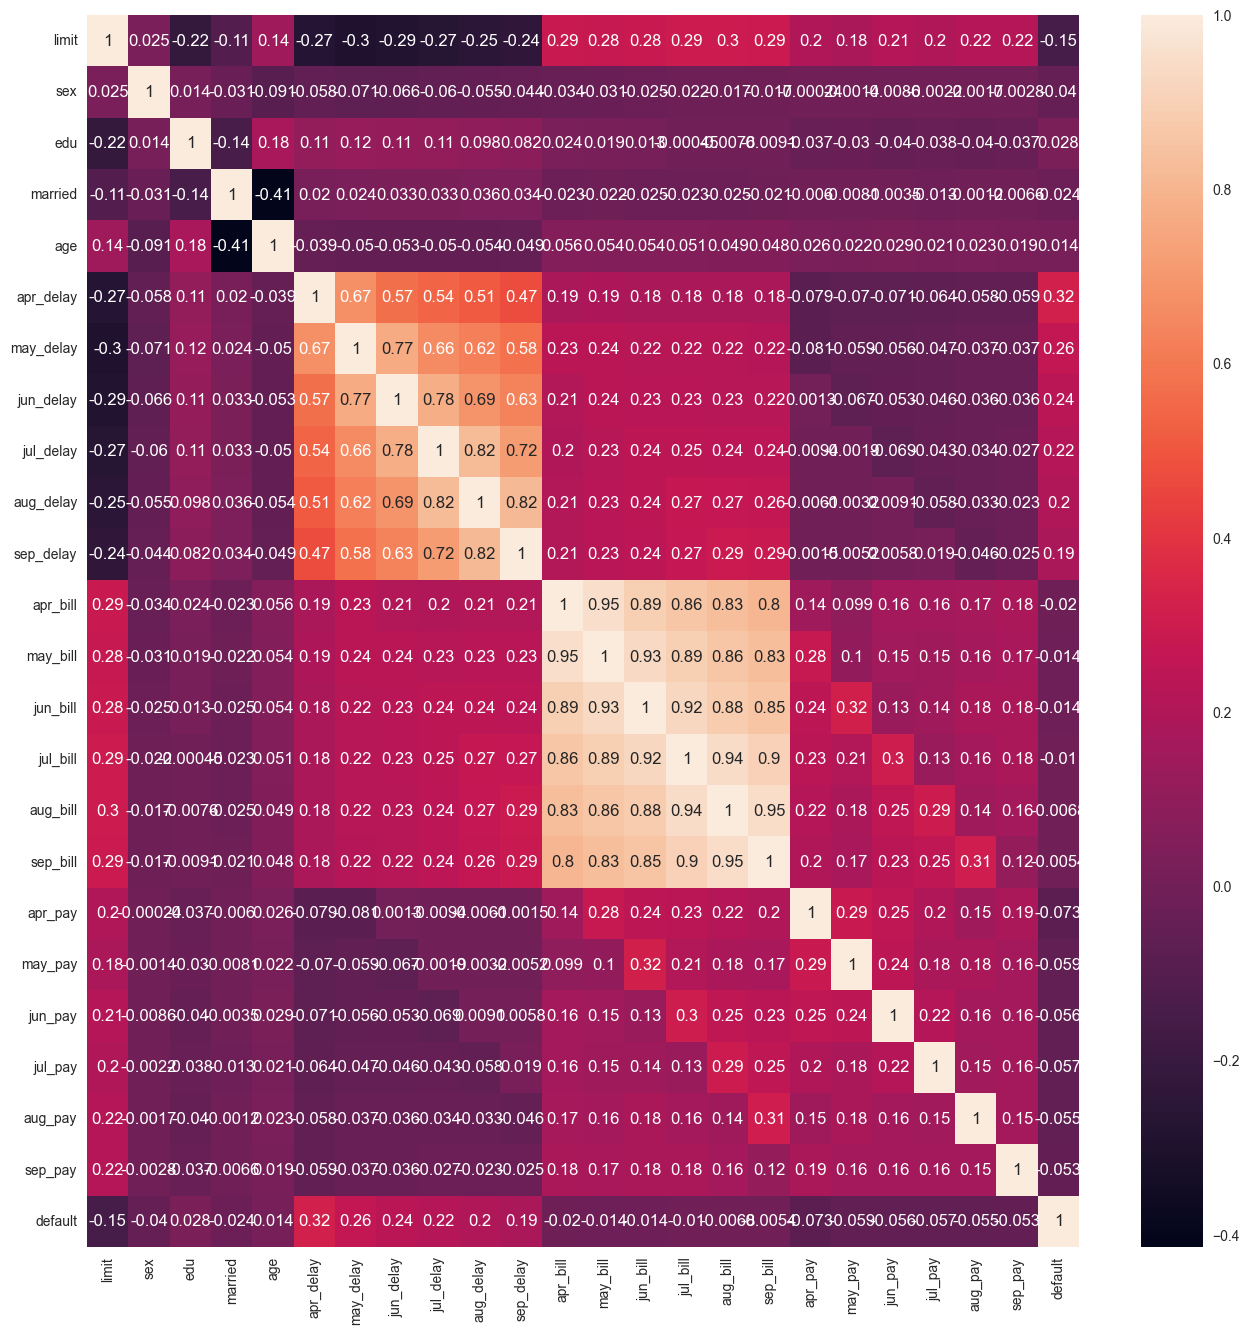

In [5]:
plt.figure(figsize=(16,16))
sns.heatmap(df_credit.corr(numeric_only=True),annot=True)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [5]:
X = df_credit.drop(columns=['default'], axis=1)
y = df_credit['default']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

In [7]:
scaler = StandardScaler()

ct = ColumnTransformer(
    [
        ("scaling", StandardScaler(), X_train.columns.tolist()),
    ]
)

In [8]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score

In [63]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

In [64]:
y_pred = knn_clf.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))

accuracy_score: 0.6641666666666667
f1_score: 0.44566712517193946
recall_score: 0.6169078446306169
precision_score: 0.3488372093023256


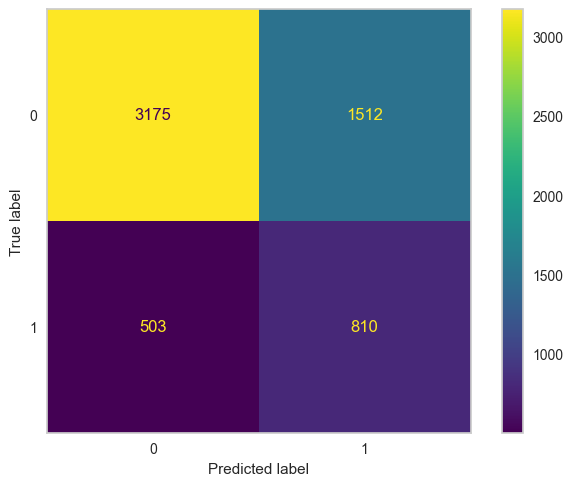

In [68]:
cm = confusion_matrix(y_test, y_pred, labels=knn_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_clf.classes_)
disp.plot()
plt.grid(visible=None)
plt.show()

In [79]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from imblearn.pipeline import Pipeline

In [87]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('classification', KNeighborsClassifier())
    ])

params_knn = {
    'classification__n_neighbors': [3,5,8,13,15],
    'classification__weights': ['uniform'],#['uniform','distance'],
    'classification__p': [2],#[1,5,10,30]
}

grid_knn = GridSearchCV(model, param_grid=params_knn, scoring='f1', cv=5,n_jobs=-1)

grid_knn.fit(X_train, y_train)
best_hyperparams = grid_knn.best_params_
print("Best hyperparameters:")
pprint(best_hyperparams)
print("\n")


best_CV_score = grid_knn.best_score_
print("Best 5-fold CV accuracy: {}".format(best_CV_score))

Best hyperparameters:
{'classification__n_neighbors': 13,
 'classification__p': 2,
 'classification__weights': 'uniform'}


Best 5-fold CV accuracy: 0.4734676796692524


Text(0, 0.5, 'F1 score')

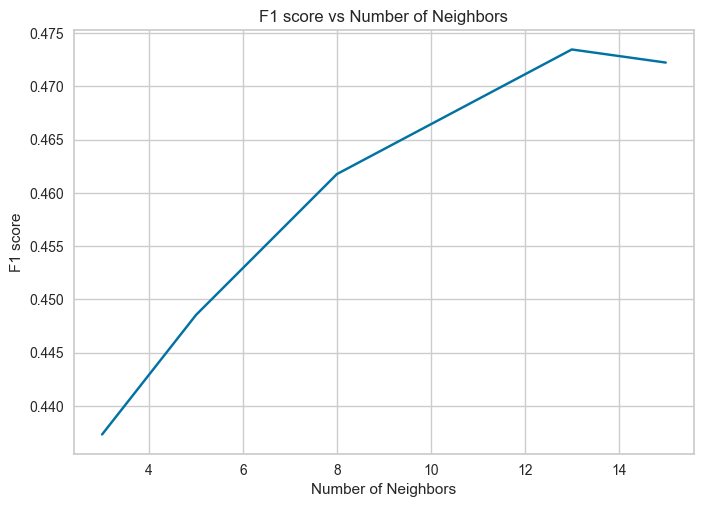

In [90]:
# plt.figure(figsize=(13,13))

results = grid_knn.cv_results_
results_df = pd.DataFrame(results)
scores = results_df['mean_test_score']
results_df

x = [3,5,8,13,15]
plt.plot(x, scores)
plt.title("F1 score vs Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("F1 score")

In [89]:
y_pred = grid_knn.best_estimator_.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))

accuracy_score: 0.6671666666666667
f1_score: 0.46732461989863966
recall_score: 0.6671744097486672
precision_score: 0.35960591133004927


In [91]:
grid_knn.best_estimator_.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()),
  ('classification', KNeighborsClassifier(n_neighbors=13))],
 'verbose': False,
 'sampling': SMOTE(),
 'classification': KNeighborsClassifier(n_neighbors=13),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'classification__algorithm': 'auto',
 'classification__leaf_size': 30,
 'classification__metric': 'minkowski',
 'classification__metric_params': None,
 'classification__n_jobs': None,
 'classification__n_neighbors': 13,
 'classification__p': 2,
 'classification__weights': 'uniform'}

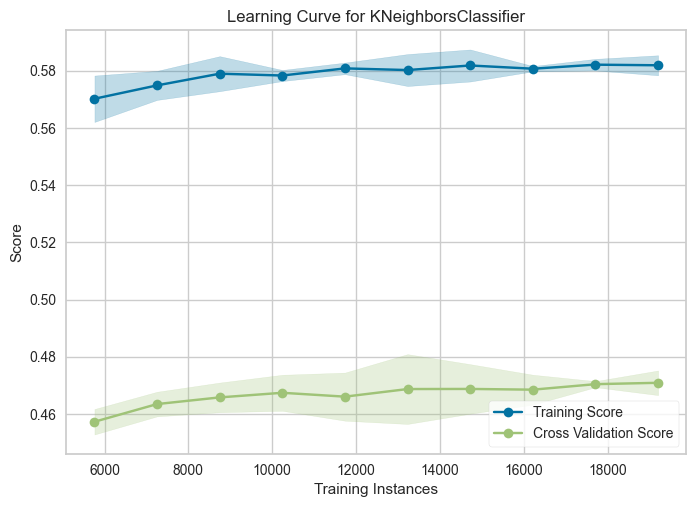

<AxesSubplot: title={'center': 'Learning Curve for KNeighborsClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [132]:
from yellowbrick.model_selection import LearningCurve
sizes = np.linspace(0.3, 1.0, 10)
visualizer = LearningCurve(
    grid_knn.best_estimator_, cv=5, scoring='f1', train_sizes=sizes, n_jobs=-1
)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show() 

In [94]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train_resampled, y_train_resampled)

SVC()

In [95]:
y_pred = svm_clf.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))

accuracy_score: 0.7776666666666666
f1_score: 0.534542916957432
recall_score: 0.5833968012185834
precision_score: 0.49323889246619446


In [97]:
svm_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [104]:
svc_model = Pipeline([
        ('sampling', SMOTE()),
        ('classification', SVC())
    ])

params_svc = {
    'classification__C': [1,3,5],
    'classification__kernel': ['rbf'], #['linear', 'poly', 'sigmoid', 'rbf'],
    'classification__degree': [1,5,10]
}

# 10-fold stratified cross validation
grid_svm = GridSearchCV(estimator=svc_model, param_grid=params_svc, scoring='f1',cv=5,n_jobs=-1)

grid_svm.fit(X_train,y_train)

best_hyperparams = grid_svm.best_params_
print("Best hyperparameters:")
pprint(best_hyperparams)
print("\n")


best_CV_score = grid_svm.best_score_
print("Best 5-fold CV accuracy: {}".format(best_CV_score))

Best hyperparameters:
{'classification__C': 1,
 'classification__degree': 1,
 'classification__kernel': 'rbf'}


Best 5-fold CV accuracy: 0.5343351640202856


In [105]:
# plt.figure(figsize=(13,13))

results = grid_svm.cv_results_
results_df = pd.DataFrame(results)
scores = results_df['mean_test_score']
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__C,param_classification__degree,param_classification__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,129.323325,0.351769,21.040920,0.432140,1,1,rbf,"{'classification__C': 1, 'classification__degr...",0.530184,0.541176,0.537567,0.532102,0.530647,0.534335,0.004315,1
1,129.337044,0.444344,21.139595,0.638773,1,5,rbf,"{'classification__C': 1, 'classification__degr...",0.529801,0.543594,0.533333,0.530450,0.528286,0.533093,0.005500,3
2,129.128954,0.428883,20.940891,0.520459,1,10,rbf,"{'classification__C': 1, 'classification__degr...",0.530290,0.544559,0.535730,0.528705,0.530349,0.533927,0.005824,2
3,156.077602,11.727169,28.175892,3.332476,3,1,rbf,"{'classification__C': 3, 'classification__degr...",0.528302,0.528912,0.527249,0.521217,0.526921,0.526520,0.002746,4
4,161.510407,1.515466,29.971135,0.305687,3,5,rbf,"{'classification__C': 3, 'classification__degr...",0.526135,0.525910,0.526681,0.522639,0.524126,0.525098,0.001499,6
5,162.957233,0.507884,30.414853,0.123178,3,10,rbf,"{'classification__C': 3, 'classification__degr...",0.529156,0.527539,0.523291,0.531579,0.519159,0.526145,0.004415,5
6,164.591801,12.781038,27.573876,1.974927,5,1,rbf,"{'classification__C': 5, 'classification__degr...",0.522116,0.522639,0.516796,0.514975,0.516928,0.518691,0.003093,7
7,160.935646,4.564233,23.539921,1.836140,5,5,rbf,"{'classification__C': 5, 'classification__degr...",0.523667,0.521449,0.515598,0.517199,0.512235,0.518030,0.004091,8
8,156.045202,3.438052,24.160978,1.520262,5,10,rbf,"{'classification__C': 5, 'classification__degr...",0.525097,0.523992,0.517873,0.509755,0.509180,0.517179,0.006763,9


In [107]:
y_pred = grid_svm.best_estimator_.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))

accuracy_score: 0.777
f1_score: 0.5301966292134831
recall_score: 0.575019040365575
precision_score: 0.49185667752442996


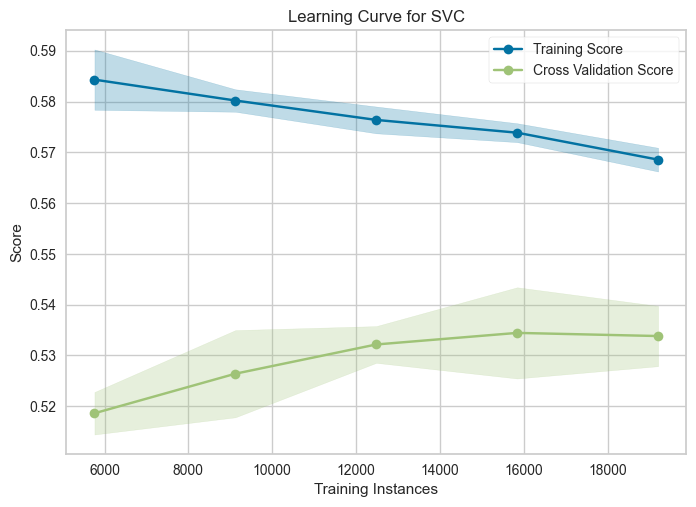

<AxesSubplot: title={'center': 'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [108]:
sizes = np.linspace(0.3, 1.0, 5)
visualizer = LearningCurve(
    grid_svm.best_estimator_, cv=5, scoring='f1', train_sizes=sizes, n_jobs=8
)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show() 

## ANN

In [13]:
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing


n_cols = X_train.shape[1]
model = keras.models.Sequential()
model.add(keras.layers.Dense(10, activation='relu', input_shape=(n_cols,)))
#model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(3, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

2024-06-09 18:38:55.594923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [125]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['F1Score'])
history_1 = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - F1Score: 0.3637 - loss: 0.5032 - val_F1Score: 0.3591 - val_loss: 0.4703
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - F1Score: 0.3660 - loss: 0.4670 - val_F1Score: 0.3591 - val_loss: 0.4552
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - F1Score: 0.3600 - loss: 0.4465 - val_F1Score: 0.3591 - val_loss: 0.4474
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - F1Score: 0.3688 - loss: 0.4475 - val_F1Score: 0.3591 - val_loss: 0.4440
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - F1Score: 0.3608 - loss: 0.4321 - val_F1Score: 0.3591 - val_loss: 0.4419
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - F1Score: 0.3604 - loss: 0.4356 - val_F1Score: 0.3591 - val_loss: 0.4397
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - F1Score: 0.3633 - loss: 0.4308 - val_F1Score: 0.3591 - val_loss: 0.4387
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - F1Score: 0.3653 - loss: 0.4356 - val_F1Score: 0.35

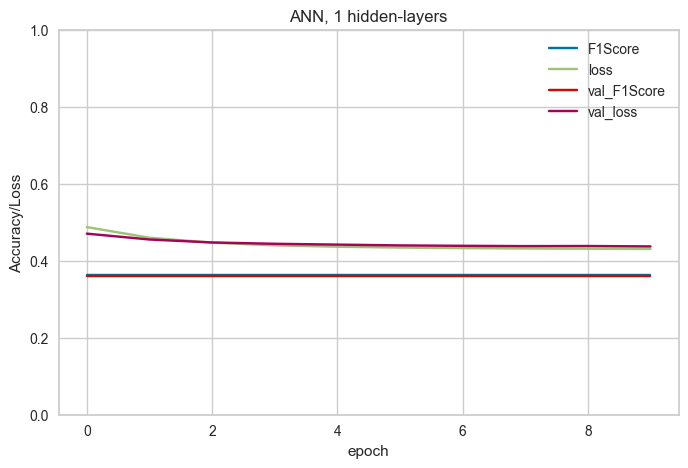

In [126]:
pd.DataFrame(history_1.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("ANN, 1 hidden-layers")
plt.ylabel("Accuracy/Loss")
plt.xlabel("epoch")
plt.show()

In [127]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_trans = le.fit_transform(y_train)
y_test_trans = le.fit_transform(y_test)
opt = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['F1Score'] )
# rand_search_cv = RandomizedSearchCV(model, param_distribs, n_iter=5, cv=3)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30


/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - F1Score: 0.3684 - loss: 0.5171 - val_F1Score: 0.3591 - val_loss: 0.4530
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - F1Score: 0.3642 - loss: 0.4541 - val_F1Score: 0.3591 - val_loss: 0.4435
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - F1Score: 0.3658 - loss: 0.4401 - val_F1Score: 0.3591 - val_loss: 0.4481
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - F1Score: 0.3666 - loss: 0.4358 - val_F1Score: 0.3591 - val_loss: 0.4406
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - F1Score: 0.3662 - loss: 0.4311 - val_F1Score: 0.3591 - val_loss: 0.4374
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - F1Score: 0.3601 - loss: 0.4248 - val_F1Score: 0.3591 - val_loss: 0.4422
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - F1Score: 0.3651 - loss: 0.4264 - val_F1Score: 0.3591 - val_loss: 0.4394
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - F1Score: 0.3695 - loss: 0.4289 - val_F1Score: 0.3591 - val_lo

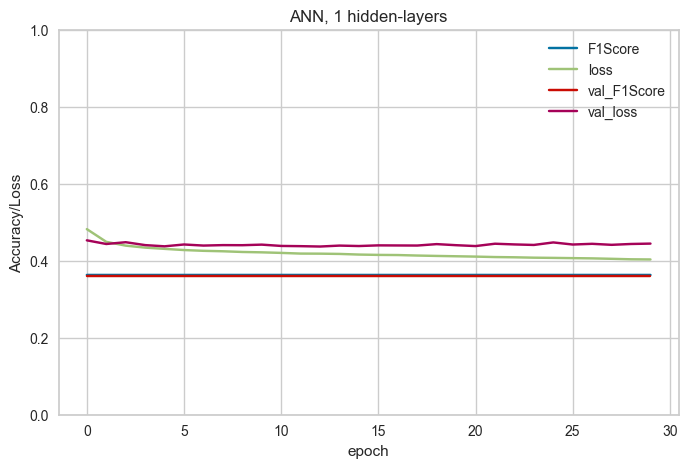

In [128]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("ANN, 1 hidden-layers")
plt.ylabel("Accuracy/Loss")
plt.xlabel("epoch")
plt.show()

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(300, activation='relu', input_shape=(n_cols,)))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_trans = le.fit_transform(y_train)
y_test_trans = le.fit_transform(y_test)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['F1Score'] )
history_2 = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

Epoch 1/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - F1Score: 0.3602 - loss: 0.4802 - val_F1Score: 0.3591 - val_loss: 0.4438
Epoch 2/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3656 - loss: 0.4444 - val_F1Score: 0.3591 - val_loss: 0.4427
Epoch 3/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3590 - loss: 0.4299 - val_F1Score: 0.3591 - val_loss: 0.4435
Epoch 4/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3579 - loss: 0.4296 - val_F1Score: 0.3591 - val_loss: 0.4408
Epoch 5/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3658 - loss: 0.4280 - val_F1Score: 0.3591 - val_loss: 0.4456
Epoch 6/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3599 - loss: 0.4257 - val_F1Score: 0.3591 - val_loss: 0.4404
Epoch 7/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3617 - loss: 0.4217 - val_F1Score: 0.3591 - val_loss: 0.4376
Epoch 8/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3623 - loss: 0.4193 - val_F1Score: 0.3591 - v

750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.4028 - loss: 0.2366 - val_F1Score: 0.3740 - val_loss: 1.1567
Epoch 52/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3907 - loss: 0.2355 - val_F1Score: 0.3762 - val_loss: 1.0479
Epoch 53/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3950 - loss: 0.2258 - val_F1Score: 0.3752 - val_loss: 1.1044
Epoch 54/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3865 - loss: 0.2215 - val_F1Score: 0.3731 - val_loss: 1.0454
Epoch 55/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3891 - loss: 0.2158 - val_F1Score: 0.3736 - val_loss: 0.9848
Epoch 56/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3990 - loss: 0.2096 - val_F1Score: 0.3830 - val_loss: 1.1986
Epoch 57/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3974 - loss: 0.2114 - val_F1Score: 0.3715 - val_loss: 1.0113
Epoch 58/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.3948 - loss: 0.2066 - val_F1Score: 0.3769 - val_lo

750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.4129 - loss: 0.1283 - val_F1Score: 0.3764 - val_loss: 1.6439
Epoch 102/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.4124 - loss: 0.1340 - val_F1Score: 0.3859 - val_loss: 1.7405
Epoch 103/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.4206 - loss: 0.1243 - val_F1Score: 0.3883 - val_loss: 1.9065
Epoch 104/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.4247 - loss: 0.1241 - val_F1Score: 0.3805 - val_loss: 1.5888
Epoch 105/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.4168 - loss: 0.1276 - val_F1Score: 0.3753 - val_loss: 1.4012
Epoch 106/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.4208 - loss: 0.1241 - val_F1Score: 0.3794 - val_loss: 1.7044
Epoch 107/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.4200 - loss: 0.1217 - val_F1Score: 0.3895 - val_loss: 1.9769
Epoch 108/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - F1Score: 0.4190 - loss: 0.1259 - val_F1Score: 0.3843 -

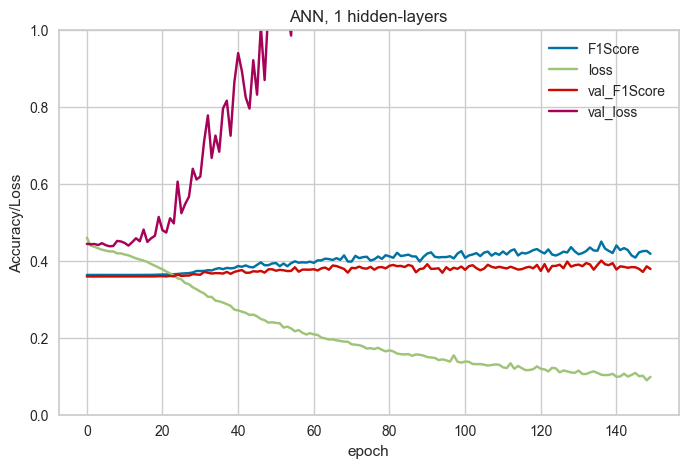

In [15]:
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("ANN, 1 hidden-layers")
plt.ylabel("Accuracy/Loss")
plt.xlabel("epoch")
plt.show()